In [1]:
!nvidia-smi

Thu Aug 11 07:35:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   27C    P8    24W / 260W |      3MiB / 48601MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:3D:00.0 Off |                  Off |
| 33%   

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  # 0번은 gpus[0] ,1번은 gpus[1] 이런식으로 사용
  try:
    tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

In [21]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [5]:
%ls

 MLPRegressor.ipynb                Untitled.ipynb    test-Copy1.ipynb
'MultiOutput XGBRegressor.ipynb'   Untitled1.ipynb   test.ipynb
 SEDA.ipynb                        __MACOSX/         tree.dot
 SGDRegressor.ipynb                cache/            wisc_bc_data.csv
 Tree.ipynb                        open-4/
'Untitled Folder'/                 open-4.zip


In [6]:
%cd open-4

/Data1/dcase_task1/Radar/open-4


In [7]:
%ls

meta/       sample_submission.csv  submit_sgd.csv  train.csv
mlp.csv     submit.csv             submit_xgb.csv  weights/
processed/  submit_rf.csv          test.csv


In [8]:
train_df = pd.read_csv('train.csv')

In [9]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

In [10]:
#Regression Model Fit
lgbm = MultiOutputRegressor(LGBMRegressor(
                        n_estimators=100,
                        learning_rate=0.08, 
                        subsample=0.75, 
                        colsample_bytree = 1, 
                        max_depth=7) ).fit(train_x, train_y)
print('Done.')

Done.


In [11]:
test_x = pd.read_csv('test.csv').drop(columns=['ID'])

In [12]:
preds = lgbm.predict(test_x)
print('Done.')

Done.


In [13]:
submit = pd.read_csv('sample_submission.csv')

In [14]:
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]
print('Done.')

Done.


In [15]:
submit.to_csv('submit_lgbm.csv', index=False)

In [16]:
#Feature Importance
fi = pd.DataFrame(lgbm.feature_importance_, index = train_x.columns, columns = ['importance']).sort_values(by='importance', ascending=False)
fi = fi[fi.importance > 0]
fi = fi.reset_index()
fi

AttributeError: 'MultiOutputRegressor' object has no attribute 'feature_importance_'

In [ ]:
fig, ax = plt.subplots()
ax = sns.barplot(y=fi['index'], x=fi['importance'])
fig.set_size_inches(18,8)

TypeError: booster must be Booster or LGBMModel.

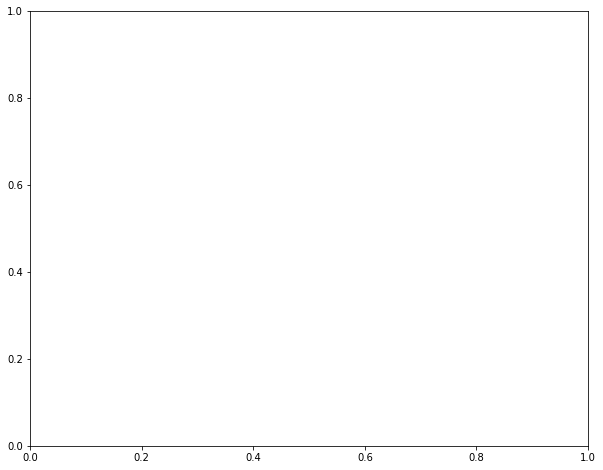

In [29]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 8))
plot_importance(lgbm, ax, max_num_features=20)